# Import librairies

In [1]:
import requests
import tweepy
import webbrowser
import time
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

# Import keys

In [2]:
from raw_data import keys

In [3]:
twitter_api_key = keys.twitter_api_key()
twitter_api_secret_key = keys.twitter_api_key_secret()
twitter_bearer_token = keys.twitter_bearer_token

# Connect my developer project to my twitter profile

In [4]:
callback_uri = "oob" # url
auth = tweepy.OAuthHandler(twitter_api_key, twitter_api_secret_key, callback_uri)
redirect_url = auth.get_authorization_url()
print(redirect_url)

https://api.twitter.com/oauth/authorize?oauth_token=ssnwMQAAAAABUe3MAAABfJPSdsU


In [5]:
m=

SyntaxError: invalid syntax (1928120398.py, line 1)

In [5]:
user_pin_value = '9122509'
auth.get_access_token(user_pin_value)
api = tweepy.API(auth)

# Load new content

## Function to extract the tweets of politicals that I follow

In [6]:
def extract_tweets_from_politics(number_of_tweet_per_politic):
    """This function return a DataFrame of the last tweets of politics that I follow on Twitter"""
    
    # Start by working on my own account
    me = api.get_user(screen_name="alecoursonnois")
    # Generate a list of my all of my friends (considering that I have under 200 friends on twitter)
    my_friends = me.friends(count=200)
    
    # Retrieve my personal friends which I don't want to analyze their tweets
    not_politics = ["alecoursonnois", "Baly_5", "LucieCMP", "JeannonoSmith", "Seezzy_"]
    
    # Create a set to stock the DataFrame columns names
    columns = set()
    # Create a list to restrict the extractions to string and int datas only
    allowed_types = [str, int]
    # Create a list to save each tweet and its datas
    tweets_data = []
    # Create to save politics screen_names
    politics_screen_name = []
    
    # Iterate on my_friends
    for friend in my_friends:
        friend_name = friend.screen_name
        
        # Don't act if this friend is out of the project
        if friend_name in not_politics:
            pass
        
        else:
            # Generate politics timeline list of the last tweets (the number must be indicated as a function's argument)
            timeline_list = api.get_user(screen_name=friend_name).timeline(count=number_of_tweet_per_politic)
            
            # Iterate on each tweet
            for status in timeline_list:
                # Generate a dictionary of status attributes
                status_dict = dict(vars(status))
                
                # From this dictionary, get the keys and stock it in a variable
                keys = vars(status).keys()
                
                # Create a dictionary stocking each status of the politic we are working on
                # Integrate the status user_screen_name and its author_screen_name
                # This dictionary will be added to the "tweets_data" list and finaly convert into a DataFrame
                single_tweet_data = {"user":status.user.screen_name, "author": status.author.screen_name}
               
                # Iterate on each status key (future column name)
                for k in keys:
                    # Check its type
                    v_type = type(status_dict[k])
                    
                    # If its in the allowed_types list there we go
                    if v_type in allowed_types:
                        # Add the status data to its right key into the dictionary of each status
                        single_tweet_data[k] = status_dict[k]
                        # Add the key as a column name in the set
                        columns.add(k)
                
                # Append the full single_tweet_data dictionary with the right key to the tweets_data list
                tweets_data.append(single_tweet_data)

    # Give a name to the columns respecting the order
    headers_cols = list(columns)
    # Add user and author column names
    headers_cols.append("user")
    headers_cols.append("author")

    # Convert the tweets_data list into a DataFrame
    df = pd.DataFrame(tweets_data)
    
    # Only keep columns that provides information
    columns_to_keep = ['user', 'author', 'id', 'text', 'source', 'source_url']
    df = df[columns_to_keep]
    
    return df

## Apply the function

In [7]:
last_tweets_df = extract_tweets_from_politics(number_of_tweet_per_politic=500)

## Add features

- Parti politique 
- Tendance politique
- Date d'extraction (pour intégrer cette information il faudrait créer une copie de l'archive sans cette colonne pour pouvoir retirer les doublons, puis, merger le df sans doublon au sauvegardé pour avoir la date d'extraction)
- Score par lexique (plus tard)

### Generate new_features

In [8]:
new_features = [{"user":'EPhilippe_LH', "political_party":"horizons", "political_trend":"right"},
                 {"user":'ZemmourEric', "political_party":"zemmour", "political_trend":"extrem_right"},
                 {"user":'EmmanuelMacron', "political_party":"LREM", "political_trend":"right"},
                 {"user":'Waechter2022', "political_party":"mouvement_ecologiste_independant", "political_trend":"ecology"},
                 {"user":'Fabien_Roussel', "political_party":"PCF", "political_trend":"extrem_left"},
                 {"user":'PhilippePoutou', "political_party":"nouveau_parti_anticapitaliste", "political_trend":"extrem_left"},
                 {"user":'jfpoisson78', "political_party":"la_voie_du_peuple", "political_trend":"extrem_right"},
                 {"user":'f_philippot', "political_party":"les_patriotes", "political_trend":"extrem_right"},
                 {"user":'vpecresse', "political_party":"soyons_libres", "political_trend":"right"},
                 {"user":'DenisPayre', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'montebourg', "political_party":"l_engagement", "political_trend":"left"},
                 {"user":'JLMelenchon', "political_party":"la_france_insoumise", "political_trend":"extrem_left"},
                 {"user":'MLP_officiel', "political_party":"front_national", "political_trend":"extrem_right"},
                 {"user":'SLeFoll', "political_party":"parti_socialiste", "political_trend":"left"},
                 {"user":'jeanlassalle', "political_party":"resistons", "political_trend":"divers"},
                 {"user":'larrouturou', "political_party":"nouvelle_donne", "political_trend":"left"},
                 {"user":'philippejuvin', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'yjadot', "political_party":"EELV", "political_trend":"ecology"},
                 {"user":'Anne_Hidalgo', "political_party":"parti_socialiste", "political_trend":"left"},
                 {"user":'gerardfiloche', "political_party":"la_gauche_democratique_et_sociale", "political_trend":"extrem_left"},
                 {"user":'dupontaignan', "political_party":"debout_la_france", "political_trend":"extrem_right"},
                 {"user":'ECiotti', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'xavierbertrand', "political_party":"la_manufacture", "political_trend":"right"},
                 {"user":'MichelBarnier', "political_party":"les_republicains", "political_trend":"right"},
                 {"user":'UPR_Asselineau', "political_party":"union_populaire_republicaine", "political_trend":"divers"},
                 {"user":'n_arthaud', "political_party":"lutte_ouvriere", "political_trend":"extrem_left"},
                 {"user":'MartinRocca12', "political_party":"constituante_2022", "political_trend":"divers"},
                 {"user":'gilleslazzarini', "political_party":"parti_politique_pour_la_paix_et_la_protection_de_la_planete", "political_trend":"divers"},
                 {"user":'AlexLanglois_', "political_party":"refondation_2022", "political_trend":"divers"},
                 {"user":'luclaf', "political_party":"une_perspective_la_6e_republique", "political_trend":"divers"},
                 {"user":'Vukuzman', "political_party":"republique_souveraine", "political_trend":"divers"},
                 {"user":'FabriceGrimal', "political_party":"la_concorde_citoyenne_2022", "political_trend":"divers"},
                 {"user":'ClaraEgger1', "political_party":"espoir_RIC_2022", "political_trend":"divers"},
                 {"user":'Cau_Marie_', "political_party":"sans_etiquette", "political_trend":"divers"},
                 {"user":'antoine27955080', "political_party":"volontaires_pour_la_france", "political_trend":"extrem_right"},
                 {"user":'regis_ollivier', "political_party":"independant", "political_trend":"right"},
                 {"user":'JaclineMouraud', "political_party":"sans_etiquette", "political_trend":"right"},
                 {"user":'HeleneThouy', "political_party":"parti_animaliste", "political_trend":"ecology"},
                 {"user":'MAZUEL_Pace', "political_party":"pace", "political_trend":"left"},
                 {"user":'MarCharlott', "political_party":"sans_etiquette", "political_trend":"left"},
                 {"user":'AguebPorterie', "political_party":"aucun", "political_trend":"left"},
                 {"user":'AnasseKazib', "political_party":"courant_communiste_revolutionnaire_revolution_permanente", "political_trend":"extrem_left"}]

In [9]:
new_features_df = pd.DataFrame(new_features)

### Merge it to last_tweets_df

In [10]:
last_tweets_df = pd.merge(left=last_tweets_df, right=new_features_df, on='user', how='left')

## Check the number of tweets per politics

In [84]:
# last_tweets_df["user"].value_counts()

## Add it to the main global DataFrame

### Load the global_df 
- and drop the last index column automatically named "Unamed: 0" when saving df to csv file

In [11]:
global_df = pd.read_csv("global_df.csv").drop(columns="Unnamed: 0")

### Add new content

In [12]:
actual_number_of_tweets = global_df.shape[0]
global_df = global_df.append(last_tweets_df, ignore_index=True)
global_df = global_df.drop_duplicates()
print(f"We just added {global_df.shape[0]-actual_number_of_tweets} tweets to our global_df")

We just added 1740 tweets to our global_df


### Save the new global_df

In [13]:
global_df.shape

(10475, 8)

In [14]:
global_df.to_csv("global_df.csv")

# Clean tweets

## Make a new df from the global one
- This way we will be allowed to drop duplicates next time we will load the global_df from the csv file

In [15]:
df_ready_for_nlp = global_df.copy()

## Retrieve recurrent regex

### Retweets

In [16]:
def retrieve_rt_retweets(df):
    new_texts = []
    
    for text in df["text"]:
        if text[:3] == 'RT ' or text[:3] == 'rt ':
            new_texts.append(text[3:])
        else:
            new_texts.append(text)
    
    df["text"] = new_texts
    
    return df

In [17]:
df_ready_for_nlp = retrieve_rt_retweets(df_ready_for_nlp)

### Links

In [18]:
def retrieve_links(df):
    pattern = re.compile("https://*")
    new_text = []

    for text in df["text"]:
        if re.search(pattern, text) is None:
            new_text.append(text)
        else:
            match_position = re.search(pattern, text).span()[0]
            new_text.append(text[:(match_position-1)])

    df["text"] = new_text
    
    return df

In [19]:
df_ready_for_nlp = retrieve_links(df_ready_for_nlp)

## Define a text_cleaner function

In [20]:
def text_cleaner(text):
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower() 
    
    # Remove accents
    unaccented_string = unidecode.unidecode(lowercased) 
    
    # Tokenize
    tokenized = word_tokenize(unaccented_string) 
    
    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()] 
    
    # Make stopword list
    stop_words = set(stopwords.words('french')) 
    
    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

## Apply the text_cleaner function

In [21]:
df_ready_for_nlp['text'] = df_ready_for_nlp['text'].apply(text_cleaner)

# Analyze tweets

## Vectorize the text and estimate the associated weight

In [52]:
# # Tuned TFidfvectorizer
# vec = TfidfVectorizer(ngram_range = (1,1), min_df=0.01, max_df = 0.05).fit(df_ready_for_nlp["text"])

# # Transform text to vectors
# vectors = vec.transform(df_ready_for_nlp["text"]) 

# # Sum of tfidf weighting by word
# sum_tfidf = vectors.sum(axis=0) 

# # Get the word and associated weight
# tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]  

# # Sort
# sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  

# sorted_tfidf_list[:10]

## Map words weight

- To retrieve once again stopwords but with WordCloud, add after "height":
- stopwords=STOPWORDS

In [51]:
# plt.subplots(figsize=(25,15))
# wordcloud = WordCloud(background_color='white', width=1920, height=1080, stopwords=STOPWORDS).generate(" ".join(df_ready_for_nlp["text"]))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

## Count iteration per word

In [38]:
# words_iteration = {}

# for text in df_ready_for_nlp["text"]:
#     tokenized_word = word_tokenize(text)
#     for word in tokenized_word:
#         if word in words_iteration:
#             words_iteration[word] += 1
#         else:
#             words_iteration[word] = 1

In [54]:
# len(words_iteration)

In [53]:
# dict(sorted(words_iteration.items(), key=lambda item: item[1], reverse=True))

## Work on lexical contents

### Define lexical variables

- Politique V
- Ecologie
- Socialiste
- Capitaliste
- Communiste
- Extreme
- Humaniste
- Santé
- 

In [32]:
political_lexicon = """démocratie,politicien,gouvernement,état,diplomatie,fédéralisme,constitution,socialisme,idéologie,économique,économie,libéralisme,régime,pouvoir,social,actualité,citoyen,monarchie,parti,Machiavel,pluralisme,opposition,parlement,stratégie,civique,dictature,gouvernant,machiavélisme,parti politique,réactionnaire,dépolitiser,diplomatique,fascisme,géopolitique,politiser,sionisme,homme d'État,opinion,politologue,progressiste,révolution,révolutionnaire,technocratie,apartheid,écologie,égalité,gauche,indépendance,nationalisme,oligarchie,populisme,réfugié,terrorisme,austérité,révolution,démagogie,polémique,diplomate,philosophe,politisation,grève,libéral,programme,sociologie,souveraineté,système,alliance,anarchie,autocratie,bipolarisation,congrès,opportunisme,politiquement,propagande,schisme,sénat,Union européenne,apolitique,débat,féodalité,impérialisme,leader,militant,parlementaire,politicard,scission,économiste,extrémisme,impérialiste,analyste,centriste,écologiste,immigration,machiavélique,arène,bourgeoisie,communiste,instabilité,mondialisation,pamphlet,science politique,société,culturel,dissidence,européenne,financier,journal,mission,multipartisme,panafricanisme,racisme,anarchisme,civil,crise,électeur,gaullisme,goulag,islamisme,majorité,marxiste,orientation,parti républicain,protectorat,scandale,terreur,transition,utopie,amnistie,coalition,courant,décentralisation,entente,extrémiste,gouvernementale,Mao ZeDong,municipale,philosophie,philosophique,relance,revue,statut,technocrate,bonapartiste,clientélisme,démocratique,religieuse,répression,séparatiste,souverainiste,capitalisme,conduite,conflit,idéologique,isolationnisme,juridique,morales,politologie,publiciste,autarcie,bureaucratie,cléricalisme,colonial,contexte,démocrate,dialogue,gestion,glasnost,institutionnel,politicailler,politicaillerie,stabilité,totalitaire,vie politique,agitation,anticléricalisme,appartenance,autruche,barre,bureau,centre,club,écologisme,éditorial,état-providence,gauchiste,gazette,homme,infléchir,institut,institutions,intégration,keynésianisme,modéré,monarchiste,morale,violence,orthodoxe,panslavisme,pression,prolétariat,province,sécession,tendance,totalitarisme,action,activiste,affaire,constitutionnelle,déflation,échiquier,encarté,extérieure,faction,habile,homme politique,indépendantiste,intérieure,interpellation,interventionnisme,junte,Marine Le Pen,nation,parlementarisme,public,quitter,réaction,religion,social-démocratie,souverainisme,sphère,syndicalisme,tribalisme,troïka,agrarien,ambiant,budgétaire,considérations,convictions,discrimination,droits civils,fédérale,féminisme,finance,Guépéou,intrigues,langue de bois,monétaire,nationalité,nihilisme,réforme,Tchéka,tempête,administrative,ambitions,assemblées,autonomie,classe ouvrière,commerciales,conservateur,conversion,ethnique,fédération,financement,intérêts,littérature,menées,nationale,opposant,personnalités,populiste,protectionniste,querelles,républicain,syndical,affaires publiques,artistiques,démographique,discrimination positive,gouverner,habileté,indépendantisme,négociation,plan,police,politiste,ruse,science,temporisation,Thucydide,abstentionniste,Académie des sciences,accession,activisme,agora,aliénation,ambitieuse,anarchiste,antiparlementaire,autonome,autonomiste"""
political_lexicon = word_tokenize(text_cleaner(political_lexicon))

In [22]:
ecology_lexicon = """écologiste,environnement,écologique,écologisme,biologie,habitat,écosystème,biosphère,économie,biodiversité,ministère,pollution,productivisme,écologue,écologie politique,développement durable,solidarité,vert,éthologie,organisme,anthropologie,biologique,bionomie,biotope,durable,interaction,recyclage,biomasse,décroissance,environnementale,étude,protection,Greenpeace,capitalisme,Noël Mamère,vivant,Nicolas Hulot,énergie,génération,biogéographie,évolution,globale,microbiologie,nature,politique,préservation,végétale,cours,Hulot,Brice Lalonde,Daniel Cohn-Bendit,Europe Écologie,Mei,naturel,trophique,Antoine Waechter,modem,abiotique,biocénose,intertidale,milieu,oikos,permaculture,phytogéographie,surpopulation,biotique,bobo,diversité,écocitoyenneté,écoguerrier,éconavigation,ethnographie,ethnologie,guilde,impact,mésologie,océanographie,théorique"""
ecology_lexicon = word_tokenize(text_cleaner(ecology_lexicon))

In [24]:
social_lexicon = """sociologie,socialisme,économique,société,culturel,contexte,inégalité,libéralisme,idéologie,individu,logement,sociologique,capitalisme,environnemental,solidarité,développement,bourgeoisie,ethnologie,pauvreté,politique,système,bien-être,organisme,humain,collectivisme,délinquance,environnement,Facebook,déterminisme,égalité,évolution,pacte,progrès,civilisation,éducatif,justice,sanitaire,statut,tabou,violence,écologique,familial,individuel,sociologue,cohésion,comportement,état-providence,juridique,moral,question,démocrate,fiscal,libéral,mouvement,action,communisme,éducation,établissement,redistribution,sociétal,tissu,collective,matriarcat,ordre,Rousseau,science,changement,domaine,économie,idéal,organisation,parenté,solidaire,travailleur,citoyen,communautaire,concept,dumping,intellectuel,progressisme,progressiste,psychologique,rejet,siège,volonté,Bourdieu,classe,financement,identité,marxiste,milieu,professionnel,socialiste,bouleversement,discrimination,droit,Durkheim,emploi,handicap,institutionnel,paradigme,syndicalisme,syndicat,aliénation,assurance,conservatisme,coopération,déviance,employeur,hiérarchie,liberté,liens,loyer,mœurs,nationalisme,niveau,racial,réformiste,révolutionnaire,simple,analyse,anomie,argot,bourgeois,endogamie,éthique,fourmi,HLM,insertion,motivation,opinion,ouvrier,pauvre,prélèvement,profession,protection,réflexion,religieux,scolaire,statistique,utopie,anarchisme,condition,Conseil économique,démocratie,éducateur,grégaire,histoire,individualiste,intérêt,philosophe,racisme,respect,salarié,stratification,anthropologique,antisocial,biologique,clivage,conformisme,constructivisme,contestation,contrat,cotisation,développement économique,fédéralisme,Hobbes,impact,individualisme,libertaire,marxisme,méritocratie,militant,mutualité,précarité,socialisation,avantage,caste,cognitif,comportemental,coopératif,démographique,dictature,écologie,effondrement,ethnique,facteurs,gaullisme,groupes,institution,laïcité,lutte des classes,phénomènes,problèmes,produit,rapport,restauration,sécurité,situation,sociabilité,apport,clan,démocratique,émergence,enjeu,étranger,fiscalité,habitude,interaction,Marx,noblesse,prévention,rang,richesse,santé,Twitter,univers,abus,anthropologie,anthropologue,bienfaisance,compétence,contestataire,défavorisé,défense,féodalité,liant,médico-social,prolétariat,réinsertion,responsabilité,salaire,sentiment,sociable,soin,vision,affable,agitation,agraire,aimable,ambition,architecture,bien,Boudon,CCAS,collectivité,comité,considérer,corporatisme,critique,égalitaire,habitus,identitaire,idéologique,impôt,moralité,ONG,orientation,partenaire,psychique,samu,sociolecte,termite,totalitarisme,adhérent,alpha,associatif,bailleur,bénéficiaires,biologie,Bonald,bureaucratie,capitaliste,cassos,codes,conflits,consensus,déclassement,fondement,habitant,habitat,Juppé,langue,légitimation,légitimité,locatif,Mauss,média,mixité,modèle,nivellement,notion,office,patriarcat,philosophie,problèmes économiques,programmes,qualité,réseautage,révolution"""
social_lexicon = word_tokenize(text_cleaner(social_lexicon))

In [25]:
capital_lexicon = """investissement,capitaliste,capitalisme,profit,investisseur,travailleur,intérêt,dette,fonds,richesse,accumulation,Marx,amortissement,revenu,actionnaire,banque,rente,placement,épargne,croissance,capitalisation,salarié,participation,privatisation,emprunt,investir,augmentation,dividende,rendement,action,marchandise,numéraire,productivité,société,production,apport,circulation,monétaire,bénéfice,consommation,économique,salaire,hausse,prolétariat,actionnariat,finance,plus-value,rentabilité,rentier,société anonyme,emploi,somme,fiscalité,propriétaire,concurrence,impôt,liquidité,loyer,propriété,accroissement,accumuler,disponible,économie,économiste,financier,inflation,remboursement,rémunération,souscription,PME,principal,acquisition,entrepreneur,exploitation,productif,versement,annuité,bien,créancier,possédant,rembourser,spéculation,valeur,bourgeoisie,capitaliser,crédit,détenteur,entreprise,immobilier,péché,salariat,baisse,bourse,marché,monopole,prêteur,rôle,taux,endettement,essentiel,immobilisation,milliard,moyens de production,part,révolution,engagés,fortune,gains,industrie,luxure,privés,répartition,achat,actif,autofinancement,caisse,capitalistique,euro,fonds de roulement,krach,acquérir,Bourdieu,commanditer,emprunteur,excédent,filiale,foncier,grossir,holding,imposable,offre publique d'achat,paie,stratégique,taux d'intérêt,capital flottant,cession,concentration,décisif,détenu,escompte,fonds d'investissement,fructifier,garantie,importants,Karl Marx,majuscule,marxiste,monnaie,mort,prolétaire,Vivendi,amorçage,apporteur,classe ouvrière,détenir,échéance,effet de levier,immatériel,impôt sur le revenu,industriel,main-d'œuvre,montant,nominal,paiement,paresse,partners,patronat,payable,pêchés,propriété privée,rachat,SARL,taxation,considérable,contribuable,droits de vote,financement,idée,improductif,nécessaire,ostéoporose,souscripteur,subsistance,textile,travail,trésorerie,acquis,agricole,augmenter,boursier,capitaux propres,dispose,dollars,établissement,étranger,question,totalité,actif circulant,Adam Smith,affairer,amalgames,amenant,anonyme,appropriation,argent,assailles,assurance,avoir,bancaire,calotte,capitaux flottants,caractéristique,cardinal,casquette,central,chapiteau,chef,cheptel,cheptel mort,chose,clé,clef,comptabilité,convenablement,correctement,critique,crucial,décupler,définissant,déterminant,diligent,diminution,dissoudre,dominant,échange,empresser,entreprenant,épargnant,espèces,Eurazeo,fondamental,grand,grave,immobiliser,indispensable,libre-échange,maître,majeur,majoritaire,mondialisation,mortel,multinationale,notable,obligatoire,oui,parfaitement,patrimoine,pécule,PIB,possessions,premier,primordial,radical,recette,reconstruction,ressource,ressources naturelles,sérieux,stock,suprême,surcapitalisation,terre,trésor,utile,viatique,vie,vif,ville,vital"""
capital_lexicon = word_tokenize(text_cleaner(capital_lexicon))

In [26]:
communist_lexicon = """communisme,socialiste,révolutionnaire,soviétique,socialisme,bolchevique,URSS,militant,capitaliste,dictature,marxiste,Marx,prolétariat,soviet,maoïste,trotskiste,bolchevik,Staline,gauche,régime,marxisme,dirigeant,Lénine,collectiviste,congrès,démocratie,Mao,maoïsme,organisation,trotskisme,capitalisme,goulag,léniniste,parti unique,Albanie,ouvrier,radical,rouge,Roumanie,stalinien,stalinisme,chinois,front,résistance,travailleur,anarchiste,fasciste,jeunesse,libération,Moscou,nationaliste,propagande,répression,KGB,Chine,lutte,république,khmers rouges,union,maccarthysme,Tchécoslovaquie,utopie,autoritaire,comité,extrême gauche,libéral,marxiste-léniniste,post-communisme,coco,Engels,guérilla,léninisme,moscoutaire,nomenklatura,gaulliste,internationale,perestroïka,scission,totalitarisme,trotskyste,antifasciste,Europe de l'Est,Front populaire,Gorbatchev,Jiangxi,Komintern,libertaire,marxisme-léninisme,parti communiste,Thorez,Tito,comité central,élection,extrême-gauche,FTP,idéologie,Kominform,partisan,SFIO,Shanghai,social-démocrate,soutien,tiers-monde,CGTU,KPD,moyens de production,pays,politburo,politique,révolution,Trotsky,UEC,Yougoslavie,clandestin,démocratique,fascisme,gouvernement,Hoxha,pacte,Varsovie,yougoslave,Blum,Brejnev,bureau,camarade,classe ouvrière,Cuba,Deng Xiaoping,Doriot,Duclos,Gottwald,Guomindang,Karl Marx,Khrouchtchev,longue marche,Mao ZeDong,PCI,PCUS,Pol Pot,progressiste,prolétarienne,RDA,tchécoslovaque,anarchisme,anticommuniste,athées,bourgeoisie,Castro,collectivisme,dictature du prolétariat,Enver Hoxha,gauchiste,Hitler,internationaliste,Malenkov,nazi,opposition,ouvrière,populaire,propriété privée,résistant,secrétaire,sympathisant,syndicaliste,totalitaire,trotskysme,anticommunisme,avril,Béla Kun,centralisme,démocrate,déstalinisation,entrisme,Georges Marchais,impérialisme,Internationale communiste,Jacques Duclos,juin,Kampuchéa,Kuomintang,mai,Maurice Thorez,partis,Quatrième Internationale,responsable,révolution russe,Taïwan,Tchang,Trotski,Union soviétique,Zinoviev,alliance,bloc,bloc de l'Est,bourgeoise,central,congrès de Tours,germano-soviétique,intervention,LCR,mouvement,pacte de Varsovie,pacte germano-soviétique,parti communiste français,RPC,spartakiste,clandestinité,dissident,guerre froide,idéologique,individualiste,nationalisation,Pékin,propriété,réformiste,titisme,titiste,tour,vietnamien,Aubervilliers,babouviste,Berlinguer,bolcheviste,Cabet,castriste,déviationniste,fédération,grand soir,indochinois,maire,manifeste,marchais,partageux,postcommunisme,post-communiste,Pravda,présidium,prolétaire,question,régime communiste,samizdat,Solidarnosc,soviétomane,staliniste,syndical,Vietnam"""
communist_lexicon = word_tokenize(text_cleaner(communist_lexicon))

In [27]:
extrem_lexicon = """pauvreté,violence,limite,extrémiste,raffinement,modéré,précipitation,gauche,vigilance,climat,rigueur,droite,dureté,rareté,intense,lenteur,simplicité,extrêmophile,condition,maigreur,excessif,extrémisme,extrémité,fou,horrible,prudence,sécheresse,violent,adoration,blanc,opposé,prostration,radical,délicatesse,groupuscule,skinhead,arctique,bout,chaleur,extrême droite,terrorisme,ultime,préciosité,sud-est,achevé,Bonifacio,effrayant,extrémiser,héroïque,nord-est,profond,température,anxiété,asservir,décrépitude,fascisme,milieu,apolitique,contraire,débilité,fleur,néonazi,sud-ouest,désolation,épuisement,obligeance,partis,sévérité,situations,fatigue,finesse,moyen,onction,pâleur,positions,tension,abstention,angoisse,circonspection,metal,militant,Sibérie,terreur,toundra,trotskiste,absolu,Airport,attentat,communisme,extrêmement,fasciste,front,hypersensibilité,immodéré,Kolyma,nationalisme,outrée,particulier,redoutable,surexcitation,survie,agitation,aigu,antisémitisme,ardeur,beauf,course,délire,discrétion,diversité,électorat,extrême gauche,facho,gravité,haut,Japon,maximal,méfiance,miséricorde,mouvance,musoir,nervosité,nord-ouest,nudité,Orient,paroxysme,pénurie,pluie,précision,Programming,puissance,rejoignent,relooking,sensibilité,végétation,xénophobie,zèle,antisémite,capitalisme,disproportion,ECW,excès,faiblesse,fragilité,froid,froidure,Front national,gentillesse,horreur,hypersexualisation,juste milieu,laideur,libéralisme,lourdeur,météorologiques,minceur,mollesse,nationaliste,nébulosité,opinions,paresseux,racisme,raciste,tenir,vivacité,abattement,anticommuniste,aridité,bonté,dernier,détresse,énergique,grand,hasardeux,individualisme,insensibilité,LCR,opposition,Paul Heyman,pôles,populiste,terroriste,agressivité,conservateur,désert,écart,extrême-gauche,férocité,inverse,légèreté,PCI,vieillesse,abusif,acharner,affreux,antipode,aride,atrocité,aux antipodes,Bièvres,borne,Cabinda,comble,compact,complet,continu,contre-pied,Couvin,définitif,démesuré,dérégler,dernière limite,désertique,désespérer,désordonné,disproportionné,draconien,drastique,durée,effréné,effroyable,éperdu,épouvantable,exagérer,exaspéré,exceptionnel,exorbitant,exquis,extase,extraordinaire,extrémisation,fin fond,final,folle,foncier,fondamental,fort,funeste,furieux,glacial,Heyman,immense,infini,inique,injuste,inouï,insupportable,intensif,Laconie,Lolita,maximum,méprisable,minimal,minutie,monstrueux,mortel,outrancier,paroxysmique,passionné,piètre,plafond,plus que ça, tu meurs,populisme,propreté,risqué,sans égal,sommet,soutenir,superlatif,suprême,surabondant,susceptibilité,tendre,terminal,terrible,tétracorde,timidité,total,Verrières-le-buisson,vertigineux,vif"""
extrem_lexicon = word_tokenize(text_cleaner(extrem_lexicon))

In [28]:
humanist_lexicon = """humanisme,renaissance,érudit,Érasme,philosophe,Montaigne,poète,savant,écologiste,philosophique,Rabelais,pacifiste,Politien,Sélestat,éducation,réformateur,théologien,Médicis,vision,Cicéron,idéal,précepteur,Florence,humain,lettré,Pétrarque,athée,florentin,intellectuel,Boccace,imprimerie,Alberti,œuvre,athéisme,culture,idées,Gargantua,grec,latin,philologie,Platon,auteur,Bessarion,humainement,imprimeur,Padoue,philologue,philosophie,rationaliste,sage,Scaliger,scolastique,sonnet"""
humanist_lexicon = word_tokenize(text_cleaner(humanist_lexicon))

In [29]:
health_lexicon = """hygiène, maladie, sanitaire, médecine, médecin, bien-être, OMS, pollution, nutrition, malade, convalescence, prévention, environnement, ministère, médical, alimentation, obésité, soin, tabagisme, assurance, éducation, précaire, professionnel, rétablissement, mental, diabète, diététique, toast, bénéfique, condition, santé publique, vaccination, hôpital, médicament, pharmacien, aliment, amélioration, complexion, état, sécurité, vitalité, néfaste, patient, épidémiologie, infantile, mortalité, sain, boire, cancer, indicateur, infirmité, nocif, pharmacie, recouvrer, régime, soignant, chiropratique, consommation, hospitalisation, altération, clinique, diagnostic, secteur, check-up, dentaire, dépistage, établissement, infirmier, longévité, paludisme, variole, épidémie, organisation, raison, bonne, bulletin, disposition, paramédical, praticien, rétablir, thérapeutique, vie, ennui, exercice, naturopathie, problème, tuberculose, alimentaire, cardiaque, dangereux, espérance, fragile, handicap, malnutrition, organisme, potable, priorité, salubrité, sida, tabac, toxique, trinquer, bien-portant, bonne santé, dentiste, guérison, impact, mauvaise, nuisible, portant, prospérité, psychiatrie, reproductive, social, valide, agence, bien portant, détérioration, mutualité, mutuelle, pathologie, pesticide, physique, prescription, protection, psychique, salubre, syndrome, tempérament, faire raison, health, hospitalière, indisposition, insalubre, institut, robuste, samu, service, traitement, alcoolisme, allaitement, améliore, cardiovasculaire, consommateur, danger, espérance de vie, infirmière, Inserm, nutritionnel, remède, salutaire, surpoids, urgence, à votre santé, biotechnologie, débile, domaine, étude, fumeur, infectieux, nuisance, sanatorium, thérapie, vaccin, vigueur, VIH, action sociale, allergie, aromathérapie, Asclépios, asthme, environnementale, généraliste, humain, informatisation, maternité, mieux-être, probiotique, psychologue, public, rendre, UNICEF, valétudinaire, activité physique, bucco-dentaire, choc, complémentaire, contamination, couleur, écosystème, embonpoint, florissant, guérir, Hippocrate, holistique, intoxication, invalidité, jouir, malaise, malaria, mondiale, montagne, naturopathe, nuisent, pôle, préoccupant, prévoyance, réadaptation, sage-femme, soigner, souffrance, altérer, animale, antioxydant, cadmium, centre hospitalier, code de la santé publique, compétence, diète, gravement, ministre de la santé, porter la santé, pouls, préoccuper, prise en charge, protection sociale, pulmonaire, santé mentale, sécurité sociale, services sociaux, shiatsu, souffrante, tempérance, transfusion, vétérinaire, vieillissement, vitamine A, atteinte, bile, corporel, dentisterie, Galien, Hygie, hypertension, IMC, innocuité, métabolique, nutriment, soins de santé, bureaucratie, détériorer, entretien, force, hypocondriaque, maigreur, maladif, malbouffe, moment, pneumonie, porter, absentéisme, aggravé, assurance maladie, caractère, communautaire, constitution, consultation, curatif, décliner, délétère, détenu, dispensaire, dossier médical, équilibre, esprit, état de santé, évaluer, hygiénisme, inhalothérapeute, interjection, massage, ménager, nature, naturel, nuigrav, personnalité, personnel soignant, préjudiciable, prosit, risque, salut, sensualité, stress, Tchin, tchin tchin, trempe """
health_lexicon = word_tokenize(text_cleaner(health_lexicon))

### Define a function to create a df with a lexicon score per user

#### Store all the lexicons in a dictionary

In [47]:
lexicon_themes = {"political": political_lexicon, "ecology": ecology_lexicon, "social":social_lexicon, "capital":capital_lexicon, "communist":communist_lexicon, "extrem":extrem_lexicon, "humanist":humanist_lexicon, "health":health_lexicon}

#### Define the function

In [157]:
def lexicon_score_per_user(df, lexicon_themes):
    """Return a DataFrame scoring each tweet contents above a list of lexicon themes"""
    # Store the users in a list
    list_of_users = list(df["user"].unique())

    # Create a list to store each future row of the DataFrame
    user_scores = []

    # For each user
    for user in list_of_users:
        # Define a dictionary to store the score per lexicon per user
        lexicon_scores = {"user" : user}
        for theme, lexicon in lexicon_themes.items():
            lexicon_scores[theme] = 0           
        
        # Extract his/her tweets
        user_tweets = list(df[df["user"]==user]["text"])
        # Then tokenize each tweet to analyze its content
        for tweet in user_tweets:
            tokenized_tweet = word_tokenize(tweet)
        
            # For each word
            for word in tokenized_tweet:
                # Is it part of one of the lexicons?
                for theme, lexicon in lexicon_themes.items():
                    if word in lexicon:
                        lexicon_scores[theme] += 1
        
        # Finally, append the user and its score per theme to user_scores
        user_scores.append(lexicon_scores)

    # Convert list to DataFrame
    lexicon_score_per_user_df = pd.DataFrame(user_scores)
    # Add political trend
    lexicon_score_per_user_df = pd.merge(left = lexicon_score_per_user_df, 
                                         right = df[["user", "political_trend"]], 
                                         on = 'user', 
                                         how = 'left')
    # User as index
    lexicon_score_per_user_df.index = df["user"]
    # Drop user column
    lexicon_score_per_user_df = lexicon_score_per_user_df.drop(columns=["user"])
    # Drop duplicates due to merge just before
    lexicon_score_per_user_df = lexicon_score_per_user_df.drop_duplicates()
    
    return lexicon_score_per_user_df

#### Apply it to df_ready_for_nlp

In [158]:
lexicon_score_per_user_df = lexicon_score_per_user(df=df_ready_for_nlp, lexicon_themes=lexicon_themes)
lexicon_score_per_user_df

,political,ecology,social,capital,communist,extrem,humanist,health,political_trend
user,,,,,,,,,
EPhilippe_LH,55,10,52,78,77,57,6,193,right
ZemmourEric,100,20,80,77,105,87,18,187,extrem_right
EmmanuelMacron,64,18,73,87,56,84,3,167,right
Fabien_Roussel,30,68,27,14,20,17,4,55,ecology
Fabien_Roussel,114,19,106,151,109,92,4,277,extrem_left
jfpoisson78,94,13,88,61,99,78,4,198,extrem_left
f_philippot,63,16,99,61,83,74,4,185,extrem_right
vpecresse,102,13,96,117,99,127,1,265,extrem_right
DenisPayre,77,24,63,62,67,59,3,197,right


### Visualize the results

<AxesSubplot:ylabel='user'>

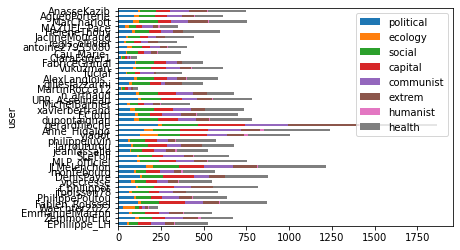

In [144]:
lexicon_score_per_user_df.plot.barh(stacked=True)

### Check the words we let behind

In [ ]:
m=

In [145]:
df_ready_for_nlp

,user,author,id,text,source,source_url,political_party,political_trend
0,EPhilippe_LH,EPhilippe_LH,1446811916698103814,avant toute horizons,Twitter for iPhone,http://twitter.com/download/iphone,horizons,right
1,EPhilippe_LH,EPhilippe_LH,1446773154693718017,voir loin faire bien merite france suivez dire...,Twitter for iPhone,http://twitter.com/download/iphone,horizons,right
2,EPhilippe_LH,EPhilippe_LH,1444968484002205704,voir loin faire bien depasser court terme cons...,Twitter for iPhone,http://twitter.com/download/iphone,horizons,right
3,EPhilippe_LH,EPhilippe_LH,1438943519356370944,jennydemay sans filtre sans maquillage certain...,Twitter for iPhone,http://twitter.com/download/iphone,horizons,right
4,EPhilippe_LH,EPhilippe_LH,1437400286247755778,soutien republicain amical a jamet a equipe mu...,Twitter for iPhone,http://twitter.com/download/iphone,horizons,right
...,...,...,...,...,...,...,...,...
16551,n_arthaud,n_arthaud,1449677800428933121,quand lallement assume regulierement faire don...,Twitter for Android,http://twitter.com/download/android,lutte_ouvriere,extrem_left
16552,n_arthaud,n_arthaud,1449403195546025986,manifestation dimanche paris souvenir commemor...,Twitter for Android,http://twitter.com/download/android,lutte_ouvriere,extrem_left
16553,n_arthaud,n_arthaud,1449342821161480195,papon lancait police manifestation algeriens t...,Twitter for Android,http://twitter.com/download/android,lutte_ouvriere,extrem_left
16554,n_arthaud,n_arthaud,1448756063877177349,menacant porter plainte contre philippe poutou...,Twitter for Android,http://twitter.com/download/android,lutte_ouvriere,extrem_left
